In [12]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode
from pyspark.sql.functions import split
from pyspark.streaming import StreamingContext
from pyspark import SparkConf, SparkContext
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from pyspark.sql.types import Row, StructType, StructField, StringType, IntegerType, TimestampType, FloatType
from pyspark.sql.functions import date_format
from pyspark.sql.functions import col, avg
from pyspark.sql.functions import udf
import math

# In Jupyter you have to stop the current context first
sc.stop()

# Create new config

conf = SparkConf().setAppName("App")
conf = (conf.setMaster('local[*]')
        .set('spark.executor.memory', '16G')
        .set('spark.driver.memory', '16G')
        .set('spark.driver.maxResultSize', '20G'))

# Create new context
sc = SparkContext(conf=conf)
spark = SparkSession \
    .builder \
    .appName("Fare prediction") \
    .getOrCreate()



In [13]:
# Read all the csv files written atomically in a directory
schema = StructType([
            StructField('key', StringType(), True),
            StructField('fare_amount', FloatType(), True),
            StructField('pickup_datetime', TimestampType(), True),
            StructField('pickup_longitude', FloatType(), True),
            StructField('pickup_latitude', FloatType(), True),
            StructField('dropoff_longitude', FloatType(), True),
            StructField('dropoff_latitude', FloatType(), True),
            StructField('passenger_count', IntegerType(), True)
            ])

streaming_df = spark \
    .readStream \
    .option("header",True)\
    .option("sep", ",") \
    .schema(schema) \
    .csv("input_files")


In [14]:
training_df = None
def convertToNormalDataFrame(df, epoch_id):
    # Transform and write batchDF
    global training_df
    training_df = df

In [15]:
streaming_df.writeStream.foreachBatch(convertToNormalDataFrame).start()

In [16]:
nyc_map = plt.imread('./nyc.png')
nyc_map_zoom = plt.imread('./nyc_zoom.png')

In [17]:
def fix_fares(df, verbose=False):
    if verbose:
        print("Removing all fares less than $2.50:")
        old_size = df.count()
        print("Old size: {}".format(old_size))

    df = df.filter(df.fare_amount>= 2.5)

    if verbose:
        new_size = df.count()
        print("New size: {}".format(new_size))
        difference = old_size - new_size
        percent = (difference / old_size) * 100
        print("Dropped {} records, or {:.2f}%".format(difference, percent))
    
    return df


#deleting all the rows with NaN,null values

def drop_nan(df, verbose=False):
    if verbose:
        print("Dropping all rows with NaNs:")
        old_size = df.count()
        print("Old size: {}".format(old_size))

    df.dropna()

    if verbose:
        new_size = df.count()
        print("New size: {}".format(new_size))
        difference = old_size - new_size
        percent = (difference / old_size) * 100
        print("Dropped {} records, or {:.2f}%".format(difference, percent))
    
    return df.na.drop()

#dropping all the rows with zeroes in their columns
def drop_0s(df, verbose=False):
    if verbose:
        print("Dropping all rows with 0s:")
        old_size = df.count()
        print("Old size: {}".format(old_size))

    df = df.filter((df["pickup_longitude"] != 0.0) & (df["dropoff_longitude"] != 0.0) & (df["dropoff_latitude"] != 0.0)\
                   & (df["pickup_latitude"] != 0.0) & (df["passenger_count"] != 0.0))

    if verbose:
        new_size = df.count()
        print("New size: {}".format(new_size))
        difference = old_size - new_size
        percent = (difference / old_size) * 100
        print("Dropped {} records, or {:.2f}%".format(difference, percent))
    
    return df

def select_within_boundingbox(df, BB):
    filter_df = df.filter((df['pickup_longitude'] >= BB[0]) & (df['pickup_longitude'] <= BB[1]) & \
           (df['pickup_latitude'] >= BB[2]) & (df['pickup_latitude'] <= BB[3]) & \
           (df['dropoff_longitude'] >= BB[0]) & (df['dropoff_longitude'] <= BB[1]) & \
           (df['dropoff_latitude'] >= BB[2]) & (df['dropoff_latitude'] <= BB[3]))
    
    return filter_df



def prepare_time_features(df, verbose=False, drop=False):

    df = df.withColumn('year', date_format('pickup_datetime', 'y')).withColumn('month', date_format('pickup_datetime', 'M'))\
            .withColumn('day_of_week', date_format('pickup_datetime', 'E')).withColumn('hour', date_format('pickup_datetime', 'HH'))\
            .withColumn('time', date_format('pickup_datetime', 'HH:mm:ss'))

    if drop:
        df = df.drop("pickup_datetime")
        df.show(2)
        
    return df

In [18]:
JFK = (-73.81, -73.77, 40.63, 40.67)

Manhattan = (-74.02, -73.93, 40.70, 40.85)

Brooklyn = (-74.01, -73.96, 40.62, 40.70)

Bronx = (-73.935, -73.88, 40.79, 40.89)

StatenIsland = (-74.20, -74.10, 40.50, 40.62)

NYC_BB = (-74.5, -72.8, 40.5, 41.8)

NYC_BB_zoom = (-74.3, -73.7, 40.5, 40.9)

training_df = fix_fares(training_df, True)
training_df.show(3)

Removing all fares less than $2.50:
Old size: 55423856
New size: 55419109
Dropped 4747 records, or 0.01%
+--------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+
|                 key|fare_amount|    pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|
+--------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+
|2009-06-15 17:26:...|        4.5|2009-06-15 17:26:21|      -73.844315|      40.721317|        -73.84161|       40.712276|              1|
|2010-01-05 16:52:...|       16.9|2010-01-05 16:52:16|      -74.016045|      40.711304|        -73.97927|       40.782005|              1|
|2011-08-18 00:35:...|        5.7|2011-08-18 00:35:00|      -73.982735|       40.76127|        -73.99124|        40.75056|              2|
+--------------------+-----------+-------------------+-------

In [19]:
training_df = drop_nan(training_df, True)

Dropping all rows with NaNs:
Old size: 55419109
New size: 55419109
Dropped 0 records, or 0.00%


In [20]:
training_df = drop_0s(training_df, True)

Dropping all rows with 0s:
Old size: 55418733
New size: 54124121
Dropped 1294612 records, or 2.34%


In [21]:
training_df = prepare_time_features(training_df, True, True)

+--------------------+-----------+----------------+---------------+-----------------+----------------+---------------+----+-----+-----------+----+--------+
|                 key|fare_amount|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|year|month|day_of_week|hour|    time|
+--------------------+-----------+----------------+---------------+-----------------+----------------+---------------+----+-----+-----------+----+--------+
|2009-06-15 17:26:...|        4.5|      -73.844315|      40.721317|        -73.84161|       40.712276|              1|2009|    6|        Mon|  17|17:26:21|
|2010-01-05 16:52:...|       16.9|      -74.016045|      40.711304|        -73.97927|       40.782005|              1|2010|    1|        Tue|  16|16:52:16|
+--------------------+-----------+----------------+---------------+-----------------+----------------+---------------+----+-----+-----------+----+--------+
only showing top 2 rows



In [22]:
def get_average_fare_rides_for_each_months(df):
    df = df.groupBy("month").avg("fare_amount")
    return df

def get_average_fare_rides_for_each_weekday(df):
    df = df.groupBy("day_of_week").avg("fare_amount")
    return df

def get_average_fare_rides_for_each_hour(df):
    df = df.groupBy("hour").avg("fare_amount")
    return df

def get_average_fare_rides_for_each_year(df):
    df = df.groupBy("year").avg("fare_amount")
    return df

def get_rush_hour_rides(df):
    df = df.select('*').where(df.hour.between(16,20))
    return df

def get_mid_night_rides(df):
    df = df.select('*').where(~df.hour.between(7,22))
    return df

def get_snow_season_rides(df):
    df = df.select('*').where(df.month.between(1,2))
    return df

In [23]:
mid_night_rides = get_mid_night_rides(training_df)
rush_hour_rides = get_rush_hour_rides(training_df)
snow_season_rides = get_snow_season_rides(training_df)

In [24]:
mid_night_rides.show(5)
rush_hour_rides.show(5)
snow_season_rides.show(5)

+--------------------+-----------+----------------+---------------+-----------------+----------------+---------------+----+-----+-----------+----+--------+
|                 key|fare_amount|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|year|month|day_of_week|hour|    time|
+--------------------+-----------+----------------+---------------+-----------------+----------------+---------------+----+-----+-----------+----+--------+
|2011-08-18 00:35:...|        5.7|      -73.982735|       40.76127|        -73.99124|        40.75056|              2|2011|    8|        Thu|  00|00:35:00|
|2012-04-21 04:30:...|        7.7|       -73.98713|      40.733143|        -73.99157|        40.75809|              1|2012|    4|        Sat|  04|04:30:42|
|2009-09-02 01:11:...|        8.9|       -73.98066|       40.73387|        -73.99154|       40.758137|              2|2009|    9|        Wed|  01|01:11:00|
|2009-11-06 01:04:...|        4.1|        -73.9916|      40.7447

In [25]:
streaming_df.createOrReplaceTempView("prediction")
bronx_rides_df = spark.sql("select * from prediction where pickup_longitude between -73.935 and -73.88 and pickup_latitude between 40.79  and 40.89 ")

In [26]:
nyc_map = plt.imread('./nyc.png')

In [27]:
def setColor(elem):
    if elem < 5.0:
        return 'r'
    elif elem > 5.0 and elem <10.0:
        return 'y'
    return 'b'

In [28]:
bronx_rides = None

def get_all_bronx_rides(df,epoch_id):
    global bronx_rides
    bronx_rides = df


In [29]:
bronx_rides_df.writeStream.foreachBatch(get_all_bronx_rides).start() 

In [30]:
bronx_rides.show(2)

+--------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+
|                 key|fare_amount|    pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|
+--------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+
|2014-03-10 19:50:...|       20.0|2014-03-10 19:50:51|       -73.89317|      40.790756|        -73.89258|       40.788483|              1|
|2012-07-22 16:36:...|        4.5|2012-07-22 16:36:14|      -73.926384|      40.808056|        -73.93513|        40.81437|              1|
+--------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+
only showing top 2 rows



In [31]:
bronx_colors = bronx_rides.select('fare_amount').rdd.map(lambda x: x[0]).map(setColor)

In [ ]:
plot_pickup_on_map(bronx_rides, NYC_BB, nyc_map,bronx_colors,'bronx_rides_nyc_map.png', s=1, alpha=0.3)

In [ ]:
jfk_rides_df=spark.sql("select * from prediction where pickup_longitude between -73.81 and -73.77 and pickup_latitude between 40.63 and 40.67 ")
manhattan_rides_df=spark.sql("select * from prediction where pickup_longitude between -74.02 and -73.93 and pickup_latitude between 40.70 and 40.85 ")
brooklyn_rides_df=spark.sql("select * from prediction where pickup_longitude between -74.01 and -73.96 and pickup_latitude between 40.62 and 40.70 ")
staten_island_rides_df=spark.sql("select * from prediction where pickup_longitude between -74.20 and -74.10 and pickup_latitude between 40.50 and 40.62 ")
rides_outside_newyork_df=spark.sql("select * from prediction where pickup_longitude between -73.935 and -73.88 and pickup_latitude between 40.79  and 40.89 ")
rides_inside_newyork_df=spark.sql("select * from prediction where pickup_longitude between -74.5 and -72.8 and pickup_latitude between 40.573143 and 41.709555 and dropoff_longitude between -74.252193 and -72.986532 and dropoff_latitude between 40.5 and 41.8")

In [32]:
jfk_rides = training_df.select("*").where("pickup_longitude between -73.81 and -73.77 and pickup_latitude between 40.63 and 40.67")

In [33]:
staten_island_rides=training_df.select("*").where("pickup_longitude between -74.20 and -74.10 and pickup_latitude between 40.50 and 40.62 ")

In [34]:
manhattan_rides = training_df.select("*").where("pickup_longitude between -74.02 and -73.93 and pickup_latitude between 40.70 and 40.85 ")


In [35]:
brooklyn_rides = training_df.select("*").where("pickup_longitude between -74.01 and -73.96 and pickup_latitude between 40.62 and 40.70 ")


In [36]:
rides_outside_newyork = training_df.select("*").where("pickup_longitude between -73.935 and -73.88 and pickup_latitude between 40.79  and 40.89 ")
rides_inside_newyork = training_df.select("*").where("pickup_longitude between -74.5 and -72.8 and pickup_latitude between 40.573143 and 41.709555 and dropoff_longitude between -74.252193 and -72.986532 and dropoff_latitude between 40.5 and 41.8")

In [37]:
jfk_colors = jfk_rides.select('fare_amount').rdd.map(lambda x: x[0]).map(setColor)


In [ ]:
plot_pickup_on_map(jfk_rides, NYC_BB, nyc_map,jfk_colors,'jfk_rides_nyc_map.png', s=1, alpha=0.3)

In [38]:
manhattan_colors = manhattan_rides.select('fare_amount').rdd.map(lambda x: x[0]).map(setColor)
manhattan_colors.take(2)

['b', 'y']

In [ ]:
plot_pickup_on_map(manhattan_rides, NYC_BB, nyc_map,manhattan_colors,'manhattan_rides_nyc_map.png', s=1, alpha=0.3)

In [39]:
brookyln_colors = brooklyn_rides.select('fare_amount').rdd.map(lambda x: x[0]).map(setColor)
brookyln_colors.take(2)

['y', 'b']

In [ ]:
plot_pickup_on_map(brooklyn_rides, NYC_BB, nyc_map,brookyln_colors,'brookyln_rides_nyc_map.png', s=1, alpha=0.3)

In [40]:
mid_night_rides_colors = mid_night_rides.select('fare_amount').rdd.map(lambda x: x[0]).map(setColor)
mid_night_rides_colors.take(2)

['y', 'y']

In [ ]:
plot_pickup_on_map(mid_night_rides, NYC_BB, nyc_map,mid_night_rides_colors,'mid_night_rides_nyc_map.png', s=1, alpha=0.3)

In [41]:
rush_hour_rides_colors = rush_hour_rides.select('fare_amount').rdd.map(lambda x: x[0]).map(setColor)
rush_hour_rides_colors.take(2)

['r', 'b']

In [ ]:
plot_pickup_on_map(rush_hour_rides, NYC_BB, nyc_map,rush_hour_rides_colors,'rush_hour_rides_nyc_map.png', s=1, alpha=0.3)

In [42]:
snow_season_rides_colors = snow_season_rides.select('fare_amount').rdd.map(lambda x: x[0]).map(setColor)
mid_night_rides_colors.take(2)

['y', 'y']

In [ ]:
plot_pickup_on_map(snow_season_rides, NYC_BB, nyc_map,snow_season_rides_colors,'snow_season_rides_nyc_map.png', s=1, alpha=0.3)

In [43]:
import numpy as np

import pyspark.sql.functions as F
from pyspark.sql.types import *


def distance(lat1, lon1, lat2, lon2):
    ## Converting degrees to radians 
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    # Haversine formula 
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(np.sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

def apply_distance(df, verbose=False):
    new_df = df.withColumn('distance_km', udfsomefunc(df.pickup_latitude, df.pickup_longitude,
                                df.dropoff_latitude, df.dropoff_longitude))
    new_df.show(2)
    if verbose:
        display(df.distance_km.describe())

    return new_df

In [65]:
from pyspark.sql.functions import udf
import math
df = training_df

udf_func = udf(distance,FloatType()) #Creating a 'User Defined Function' to calculate distance between two points.


In [66]:
df = mid_night_rides
mid_night_rides = df.withColumn("distance_km",udf_func(df.pickup_latitude, df.pickup_longitude, df.dropoff_latitude, df.dropoff_longitude)) #Creating column "distance" based on function 'get_distance'
mid_night_rides.show(2)


+--------------------+-----------+----------------+---------------+-----------------+----------------+---------------+----+-----+-----------+----+--------+-----------+
|                 key|fare_amount|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|year|month|day_of_week|hour|    time|distance_km|
+--------------------+-----------+----------------+---------------+-----------------+----------------+---------------+----+-----+-----------+----+--------+-----------+
|2011-08-18 00:35:...|        5.7|      -73.982735|       40.76127|        -73.99124|        40.75056|              2|2011|    8|        Thu|  00|00:35:00|   1.389632|
|2012-04-21 04:30:...|        7.7|       -73.98713|      40.733143|        -73.99157|        40.75809|              1|2012|    4|        Sat|  04|04:30:42|  2.7992105|
+--------------------+-----------+----------------+---------------+-----------------+----------------+---------------+----+-----+-----------+----+--------+-----

In [67]:
df = snow_season_rides
snow_season_rides = df.withColumn("distance_km",udf_func(df.pickup_latitude, df.pickup_longitude, df.dropoff_latitude, df.dropoff_longitude)) #Creating column "distance" based on function 'get_distance'
snow_season_rides.show(2)

+--------------------+-----------+----------------+---------------+-----------------+----------------+---------------+----+-----+-----------+----+--------+-----------+
|                 key|fare_amount|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|year|month|day_of_week|hour|    time|distance_km|
+--------------------+-----------+----------------+---------------+-----------------+----------------+---------------+----+-----+-----------+----+--------+-----------+
|2010-01-05 16:52:...|       16.9|      -74.016045|      40.711304|        -73.97927|       40.782005|              1|2010|    1|        Tue|  16|16:52:16|   8.450001|
|2011-01-06 09:50:...|       12.1|       -74.00096|       40.73163|        -73.97289|       40.758232|              1|2011|    1|        Thu|  09|09:50:45|   3.787118|
+--------------------+-----------+----------------+---------------+-----------------+----------------+---------------+----+-----+-----------+----+--------+-----

In [68]:
df = rush_hour_rides
rush_hour_rides = df.withColumn("distance_km",udf_func(df.pickup_latitude, df.pickup_longitude, df.dropoff_latitude, df.dropoff_longitude)) #Creating column "distance" based on function 'get_distance'
rush_hour_rides.show(3)

+--------------------+-----------+----------------+---------------+-----------------+----------------+---------------+----+-----+-----------+----+--------+-----------+
|                 key|fare_amount|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|year|month|day_of_week|hour|    time|distance_km|
+--------------------+-----------+----------------+---------------+-----------------+----------------+---------------+----+-----+-----------+----+--------+-----------+
|2009-06-15 17:26:...|        4.5|      -73.844315|      40.721317|        -73.84161|       40.712276|              1|2009|    6|        Mon|  17|17:26:21|  1.0307422|
|2010-01-05 16:52:...|       16.9|      -74.016045|      40.711304|        -73.97927|       40.782005|              1|2010|    1|        Tue|  16|16:52:16|   8.450001|
|2012-11-20 20:35:...|        7.5|          -73.98|      40.751663|         -73.9738|       40.764843|              1|2012|   11|        Tue|  20|20:35:00|  1.5

In [94]:
df = bronx_rides
bronx_rides = df.withColumn("distance_km",udf_func(df.pickup_latitude, df.pickup_longitude, df.dropoff_latitude, df.dropoff_longitude)) #Creating column "distance" based on function 'get_distance'

In [95]:
bronx_rides.show(3)

+--------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+-----------+
|                 key|fare_amount|    pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|distance_km|
+--------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+-----------+
|2014-03-10 19:50:...|       20.0|2014-03-10 19:50:51|       -73.89317|      40.790756|        -73.89258|       40.788483|              1| 0.25772458|
|2012-07-22 16:36:...|        4.5|2012-07-22 16:36:14|      -73.926384|      40.808056|        -73.93513|        40.81437|              1|  1.0169896|
|2015-01-11 22:45:...|        9.5|2015-01-11 22:45:59|         -73.908|       40.85738|        -73.90807|        40.85736|              1|0.006757845|
+--------------------+-----------+-------------------+----------------+---------------+-------

In [50]:
df = brooklyn_rides
brooklyn_rides = df.withColumn("distance_km",udf_func(df.pickup_latitude, df.pickup_longitude, df.dropoff_latitude, df.dropoff_longitude)) #Creating column "distance" based on function 'get_distance'


In [70]:
brooklyn_rides.show(2)

+--------------------+-----------+----------------+---------------+-----------------+----------------+---------------+----+-----+-----------+----+--------+-----------+
|                 key|fare_amount|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|year|month|day_of_week|hour|    time|distance_km|
+--------------------+-----------+----------------+---------------+-----------------+----------------+---------------+----+-----+-----------+----+--------+-----------+
|2012-05-04 06:11:...|        9.3|       -73.98926|      40.690834|       -74.004135|        40.72569|              1|2012|    5|        Fri|  06|06:11:20|  4.0735116|
|2014-09-12 23:10:...|       16.5|       -73.98383|      40.676052|       -74.002525|       40.723145|              1|2014|    9|        Fri|  23|23:10:00|   5.468393|
+--------------------+-----------+----------------+---------------+-----------------+----------------+---------------+----+-----+-----------+----+--------+-----

In [72]:
df = rides_inside_newyork
rides_inside_newyork = df.withColumn("distance_km",udf_func(df.pickup_latitude, df.pickup_longitude, df.dropoff_latitude, df.dropoff_longitude)) #Creating column "distance" based on function 'get_distance'


In [73]:
rides_inside_newyork.show(2)

+--------------------+-----------+----------------+---------------+-----------------+----------------+---------------+----+-----+-----------+----+--------+-----------+
|                 key|fare_amount|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|year|month|day_of_week|hour|    time|distance_km|
+--------------------+-----------+----------------+---------------+-----------------+----------------+---------------+----+-----+-----------+----+--------+-----------+
|2009-06-15 17:26:...|        4.5|      -73.844315|      40.721317|        -73.84161|       40.712276|              1|2009|    6|        Mon|  17|17:26:21|  1.0307422|
|2010-01-05 16:52:...|       16.9|      -74.016045|      40.711304|        -73.97927|       40.782005|              1|2010|    1|        Tue|  16|16:52:16|   8.450001|
+--------------------+-----------+----------------+---------------+-----------------+----------------+---------------+----+-----+-----------+----+--------+-----

In [74]:
df = manhattan_rides
manhattan_rides = df.withColumn("distance_km",udf_func(df.pickup_latitude, df.pickup_longitude, df.dropoff_latitude, df.dropoff_longitude)) #Creating column "distance" based on function 'get_distance'


In [75]:
manhattan_rides.show(2)

+--------------------+-----------+----------------+---------------+-----------------+----------------+---------------+----+-----+-----------+----+--------+-----------+
|                 key|fare_amount|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|year|month|day_of_week|hour|    time|distance_km|
+--------------------+-----------+----------------+---------------+-----------------+----------------+---------------+----+-----+-----------+----+--------+-----------+
|2010-01-05 16:52:...|       16.9|      -74.016045|      40.711304|        -73.97927|       40.782005|              1|2010|    1|        Tue|  16|16:52:16|   8.450001|
|2011-08-18 00:35:...|        5.7|      -73.982735|       40.76127|        -73.99124|        40.75056|              2|2011|    8|        Thu|  00|00:35:00|   1.389632|
+--------------------+-----------+----------------+---------------+-----------------+----------------+---------------+----+-----+-----------+----+--------+-----

In [76]:
df = jfk_rides
jfk_rides = df.withColumn("distance_km",udf_func(df.pickup_latitude, df.pickup_longitude, df.dropoff_latitude, df.dropoff_longitude)) #Creating column "distance" based on function 'get_distance'


In [79]:
jfk_rides.show(3)

+--------------------+-----------+----------------+---------------+-----------------+----------------+---------------+----+-----+-----------+----+--------+-----------+
|                 key|fare_amount|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|year|month|day_of_week|hour|    time|distance_km|
+--------------------+-----------+----------------+---------------+-----------------+----------------+---------------+----+-----+-----------+----+--------+-----------+
|2010-05-28 21:33:...|       16.1|      -73.789505|       40.64704|        -73.81562|       40.680363|              1|2010|    5|        Fri|  21|21:33:07|   4.310495|
|2013-06-14 17:37:...|      57.33|       -73.78113|      40.645008|       -73.981804|       40.762516|              1|2013|    6|        Fri|  17|17:37:00|  21.374847|
|2012-03-10 22:53:...|       26.5|       -73.77675|      40.645264|       -73.813805|       40.709034|              1|2012|    3|        Sat|  22|22:53:25|   7.

In [ ]:

## First calculate two arrays with datapoint density per sq km
n_lon, n_lat = 200, 200 # number of grid bins per longitude, latitude dimension
density_pickup, density_dropoff = np.zeros((n_lat, n_lon)), np.zeros((n_lat, n_lon)) # Prepare arrays

"""
To calculate the number of datapoints in a grid area, the numpy.digitize() function is used. 
This function needs an array with the (location) bins for counting the number of datapoints per bin.
"""
bins_lon = np.zeros(n_lon+1) # bin
bins_lat = np.zeros(n_lat+1) # bin

delta_lon = (NYC_BB[1]-NYC_BB[0]) / n_lon # bin longutide width
delta_lat = (NYC_BB[3]-NYC_BB[2]) / n_lat # bin latitude height

bin_width_kms = distance(NYC_BB[2], NYC_BB[1], NYC_BB[2], NYC_BB[0]) / n_lon # Bin width in kms
bin_height_kms = distance(NYC_BB[3], NYC_BB[0], NYC_BB[2], NYC_BB[0]) / n_lat # Bin height in kms

for i in range(n_lon+1):
    bins_lon[i] = NYC_BB[0] + i * delta_lon

for j in range(n_lat+1):
    bins_lat[j] = NYC_BB[2] + j * delta_lat
    
## Digitize per longitude, latitude dimension


inds_pickup_lon = np.digitize(training_df.select('pickup_longitude').rdd.flatMap(lambda x: x).collect(), bins_lon)
inds_pickup_lat = np.digitize(training_df.select('pickup_latitude').rdd.flatMap(lambda x: x).collect(), bins_lat)
inds_dropoff_lon = np.digitize(training_df.select('dropoff_longitude').rdd.flatMap(lambda x: x).collect(), bins_lon)
inds_dropoff_lat = np.digitize(training_df.select('dropoff_latitude').rdd.flatMap(lambda x: x).collect(), bins_lat)

"""
Count per grid bin
note: as the density_pickup will be displayed as image, the first index is the y-direction, 
      the second index is the x-direction. Also, the y-direction needs to be reversed for
      properly displaying (therefore the (n_lat-j) term)
"""
dxdy = bin_width_kms * bin_height_kms

for i in range(n_lon):
    for j in range(n_lat):
        density_pickup[j, i] = np.sum((inds_pickup_lon==i+1) & (inds_pickup_lat==(n_lat-j))) / dxdy
        density_dropoff[j, i] = np.sum((inds_dropoff_lon==i+1) & (inds_dropoff_lat==(n_lat-j))) / dxdy

In [ ]:
## Plot the density arrays
fig, axs = plt.subplots(2, 1, figsize=(18, 24))

axs[0].imshow(nyc_map, zorder=0, extent=NYC_BB);
im = axs[0].imshow(np.log1p(density_pickup), zorder=1, extent=NYC_BB, alpha=0.6, cmap='plasma')
axs[0].set_title('Pickup density [datapoints per sq km]')
cbar = fig.colorbar(im, ax=axs[0])
cbar.set_label('log(1 + # datapoints per sq km)', rotation=270)

axs[1].imshow(nyc_map, zorder=0, extent=NYC_BB);
im = axs[1].imshow(np.log1p(density_dropoff), zorder=1, extent=NYC_BB, alpha=0.6, cmap='plasma')
axs[1].set_title('Dropoff density [datapoints per sq km]')
cbar = fig.colorbar(im, ax=axs[1])
cbar.set_label('log(1 + # datapoints per sq km)', rotation=270)
fig.savefig('density_plot.png')

In [80]:
pd_brooklyn_rides_df = brooklyn_rides.toPandas()

In [100]:
pd_bronx_rides_df = bronx_rides.show(3)

+--------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+-----------+
|                 key|fare_amount|    pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|distance_km|
+--------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+-----------+
|2014-03-10 19:50:...|       20.0|2014-03-10 19:50:51|       -73.89317|      40.790756|        -73.89258|       40.788483|              1| 0.25772458|
|2012-07-22 16:36:...|        4.5|2012-07-22 16:36:14|      -73.926384|      40.808056|        -73.93513|        40.81437|              1|  1.0169896|
|2015-01-11 22:45:...|        9.5|2015-01-11 22:45:59|         -73.908|       40.85738|        -73.90807|        40.85736|              1|0.006757845|
+--------------------+-----------+-------------------+----------------+---------------+-------

In [82]:
pd_jfk_rides_df = jfk_rides.toPandas()

In [ ]:
pd_bronx_rides_df.distance_km.hist(bins=2, figsize=(12,4))
plt.xlabel('distance km')
plt.title('Histogram ride distances in km for Bronx')

Text(0.5, 1.0, 'Histogram ride distances in km for JFK')

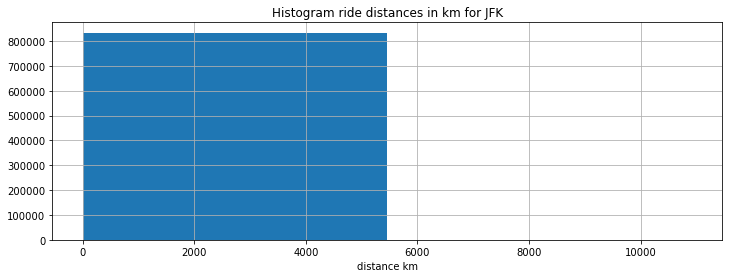

In [84]:
pd_jfk_rides_df.distance_km.hist(bins=2, figsize=(12,4))
plt.xlabel('distance km')
plt.title('Histogram ride distances in km for JFK')

Text(0.5, 1.0, 'Histogram ride distances in km for Brooklyn')

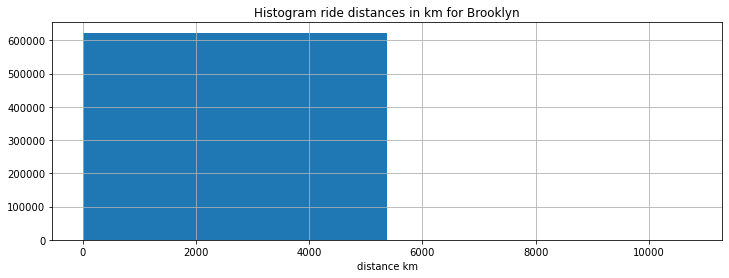

In [85]:
pd_brooklyn_rides_df.distance_km.hist(bins=2, figsize=(12,4))
plt.xlabel('distance km')
plt.title('Histogram ride distances in km for Brooklyn')

In [ ]:
pd_bronx_rides_df.groupby('passenger_count')['distance_km', 'fare_amount'].mean()

In [ ]:
print("Average $USD/km in Bronx: {:0.2f}".format(pd_bronx_rides_df.fare_amount.sum()/pd_bronx_rides_df.distance_km.sum()))

In [88]:
pd_jfk_rides_df.groupby('passenger_count')['distance_km', 'fare_amount'].mean()

<ipython-input-88-c9d7a660324f>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  pd_jfk_rides_df.groupby('passenger_count')['distance_km', 'fare_amount'].mean()


,distance_km,fare_amount
passenger_count,,
1,17.191227,43.267097
2,18.117353,45.224491
3,18.336370,44.684185
4,17.549566,45.234299
5,17.718653,42.734066
6,18.946846,46.649357
7,0.002121,70.000000


In [89]:
print("Average $USD/km in JFK: {:0.2f}".format(pd_jfk_rides_df.fare_amount.sum()/pd_jfk_rides_df.distance_km.sum()))

Average $USD/km in JFK: 2.50


In [90]:
pd_brooklyn_rides_df.groupby('passenger_count')['distance_km', 'fare_amount'].mean()

<ipython-input-90-5da2b25fea22>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  pd_brooklyn_rides_df.groupby('passenger_count')['distance_km', 'fare_amount'].mean()


,distance_km,fare_amount
passenger_count,,
1,5.028916,13.572114
2,4.633560,13.362353
3,4.566855,13.624399
4,4.729630,13.729258
5,5.797390,13.350121
6,7.196669,14.532089
7,10.036675,25.000000


In [91]:
print("Average $USD/km in Brooklyn: {:0.2f}".format(pd_brooklyn_rides_df.fare_amount.sum()/pd_brooklyn_rides_df.distance_km.sum()))

Average $USD/km in Brooklyn: 2.68


In [ ]:
## Scatter plot distance - fare
fig, axs = plt.subplots(1, 2, figsize=(16,6))
axs[0].scatter(pd_bronx_rides_df.distance_km, pd_bronx_rides_df.fare_amount, alpha=0.2)
axs[0].set_xlabel('distance km')
axs[0].set_ylabel('fare $USD')
axs[0].set_title('Bronx data')
fig.savefig('bronx_distance_vs_fare_all.png')

## Zoom in on part of data
idx = (pd_bronx_rides_df.distance_km < 30) & (pd_bronx_rides_df.fare_amount < 100)
axs[1].scatter(pd_bronx_rides_df[idx].distance_km, pd_bronx_rides_df[idx].fare_amount, alpha=0.2)
axs[1].set_xlabel('Bronx distance km')
axs[1].set_ylabel('Bronx fare $USD')
axs[1].set_title('Bronx -> Zoom in on distance < 30 km, fare < $100');
fig.savefig('bronx_distance_vs_fare_zoomed.png')

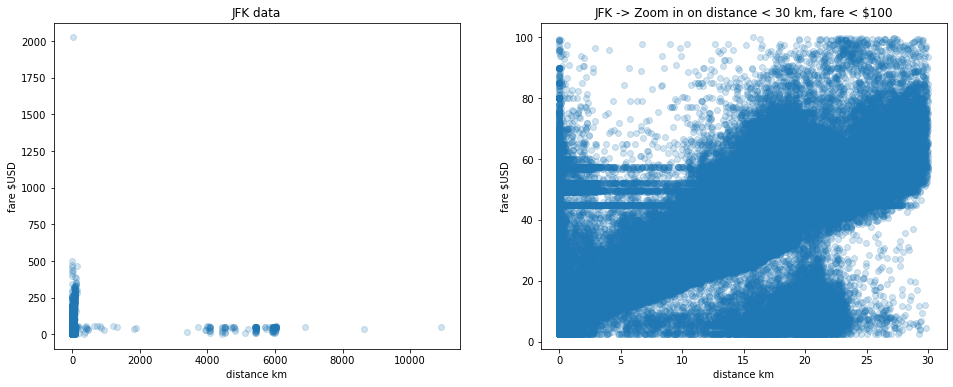

In [92]:
## Scatter plot distance - fare
fig, axs = plt.subplots(1, 2, figsize=(16,6))
axs[0].scatter(pd_jfk_rides_df.distance_km, pd_jfk_rides_df.fare_amount, alpha=0.2)
axs[0].set_xlabel('distance km')
axs[0].set_ylabel('fare $USD')
axs[0].set_title('JFK data')
fig.savefig('jfk_distance_vs_fare_all.png')

## Zoom in on part of data
idx = (pd_jfk_rides_df.distance_km < 30) & (pd_jfk_rides_df.fare_amount < 100)
axs[1].scatter(pd_jfk_rides_df[idx].distance_km, pd_jfk_rides_df[idx].fare_amount, alpha=0.2)
axs[1].set_xlabel('distance km')
axs[1].set_ylabel('fare $USD')
axs[1].set_title('JFK -> Zoom in on distance < 30 km, fare < $100');
fig.savefig('jfk_distance_vs_fare_zoomed.png')

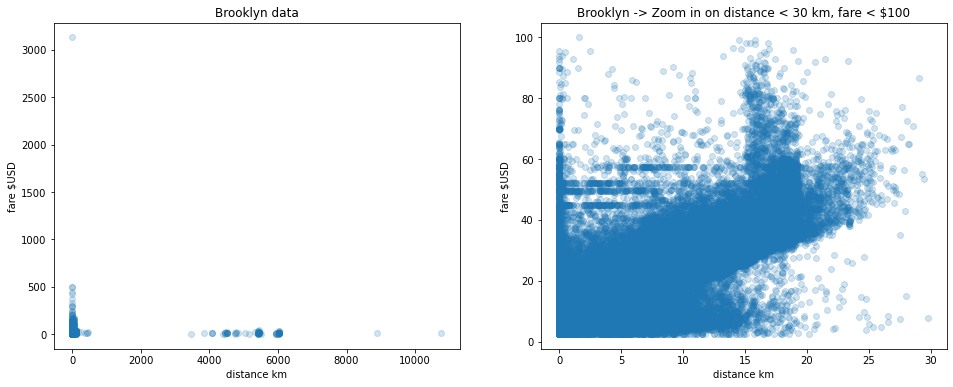

In [93]:
## Scatter plot distance - fare
fig, axs = plt.subplots(1, 2, figsize=(16,6))
axs[0].scatter(pd_brooklyn_rides_df.distance_km, pd_brooklyn_rides_df.fare_amount, alpha=0.2)
axs[0].set_xlabel('distance km')
axs[0].set_ylabel('fare $USD')
axs[0].set_title('Brooklyn data')
fig.savefig('brooklyn_distance_vs_fare_all.png')

## Zoom in on part of data
idx = (pd_brooklyn_rides_df.distance_km < 30) & (pd_brooklyn_rides_df.fare_amount < 100)
axs[1].scatter(pd_brooklyn_rides_df[idx].distance_km, pd_brooklyn_rides_df[idx].fare_amount, alpha=0.2)
axs[1].set_xlabel('distance km')
axs[1].set_ylabel('fare $USD')
axs[1].set_title('Brooklyn -> Zoom in on distance < 30 km, fare < $100');
fig.savefig('brooklyn_distance_vs_fare_zoomed.png')